
### **Project: Employee Turnover Prediction**

-----

#### **1. Introduction**




#  Employee Turnover Prediction

##  Problem Scenario

Portobello Tech, an app innovator, wants to predict employee turnover. They have collected data on employees' work details, including satisfaction levels, performance evaluations, project counts, working hours, tenure, promotions, and salary. The Human Resources (HR) department will use this data to identify patterns and predict which valuable employees are at risk of leaving.

As the Machine Learning Developer, the task is to build a model that can predict employee turnover and provide insights for retention strategies.


-----

#### **2. Setup and Data Loading**

Now, let's import the necessary libraries and load the dataset. The initial notebook already has the code to load the data, but we'll add all the required libraries for the entire project in one place for better organization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load the dataset
df = pd.read_csv('HR_comma_sep.csv')

# Display the first few rows
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


-----

#### **3. Data Quality Check**

Next, we'll perform some initial data quality checks. The original notebook already checks for nulls and duplicates, which is a great start. We will add a step to drop the duplicates.


### 3.1. Checking for Missing Values and Duplicates

We'll start by checking for any missing values in the dataset and see if there are any duplicate rows.


In [2]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Drop duplicate rows
df.drop_duplicates(inplace=True)
print(f"\nShape of the dataframe after dropping duplicates: {df.shape}")

Missing values in each column:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

Number of duplicate rows: 3008

Shape of the dataframe after dropping duplicates: (11991, 10)


-----

#### **4. Exploratory Data Analysis (EDA)**

Now, let's dive into the data to understand the factors that contribute most to employee turnover.


### 4.1. Correlation Matrix

A correlation matrix will help us understand the linear relationships between the numerical features in our dataset.


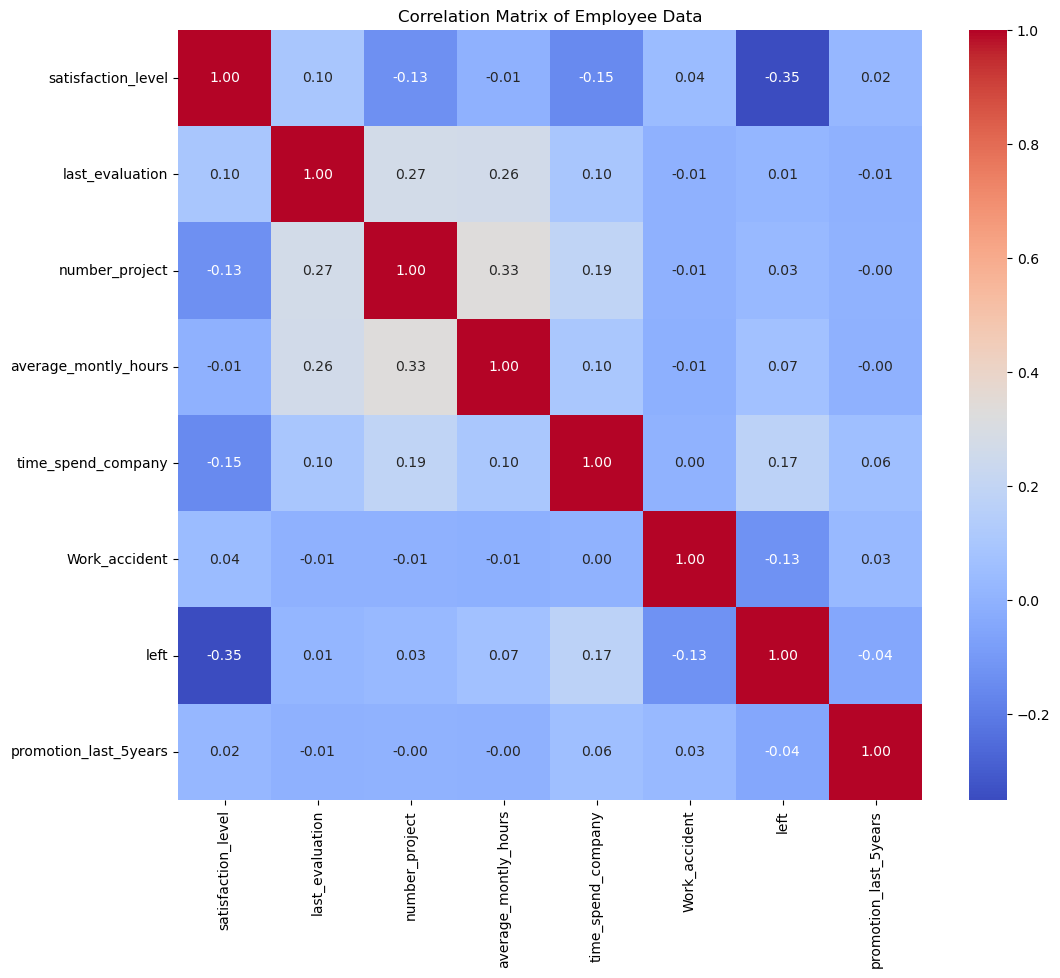

In [3]:
# Calculate and display the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Employee Data')
plt.show()


### 4.2. Satisfaction Level Distribution

Let's visualize the distribution of satisfaction levels for employees who stayed versus those who left. This will give us a good idea of how satisfaction impacts turnover.


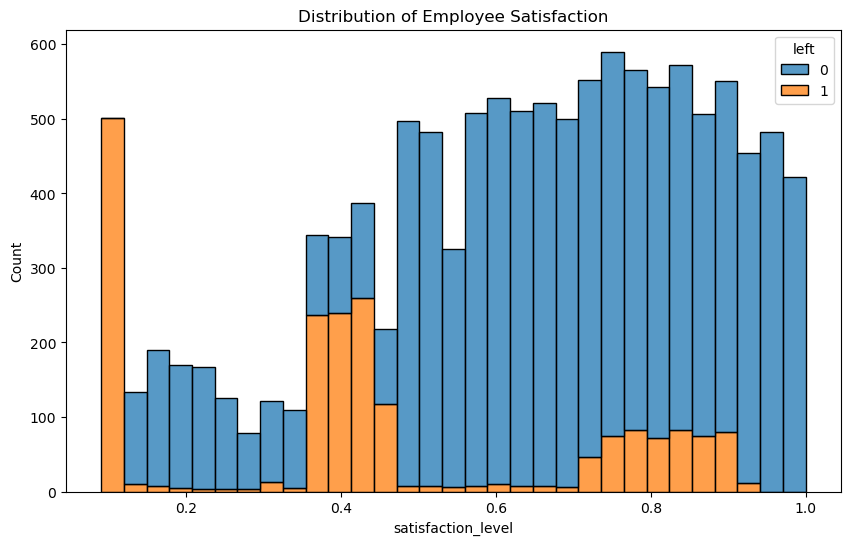

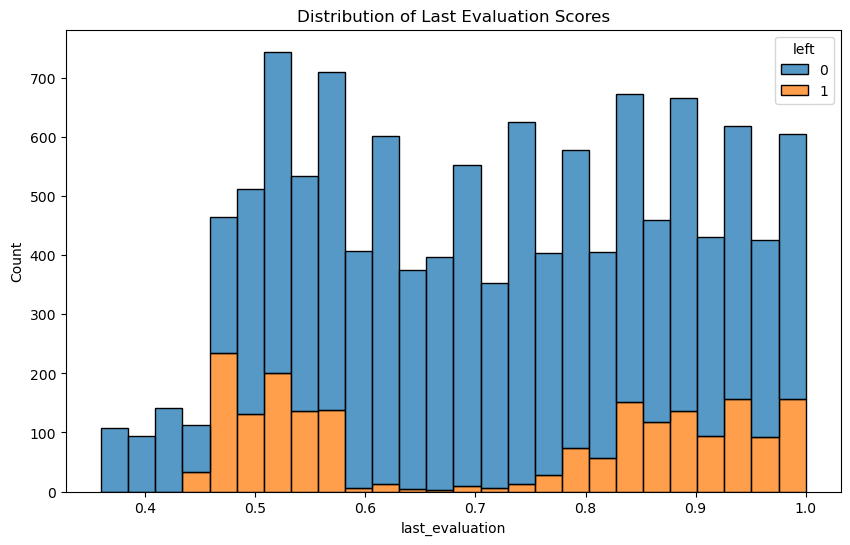

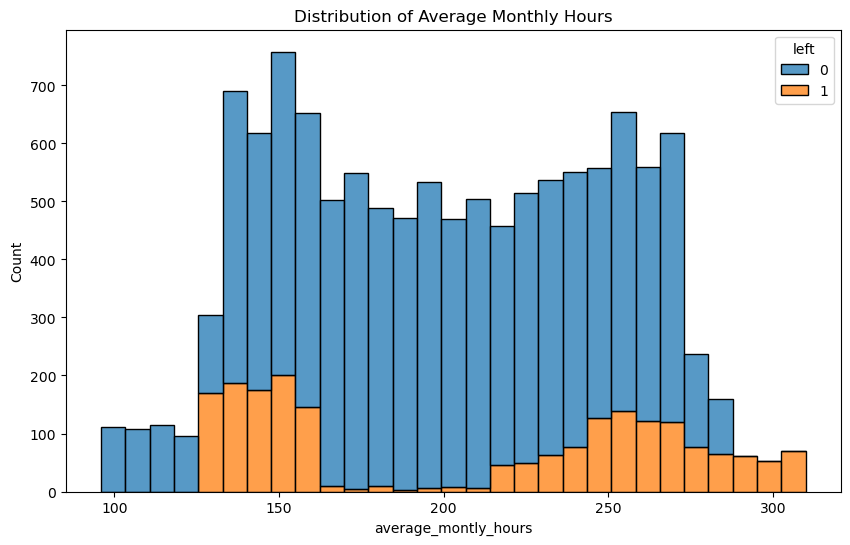

In [4]:
# Distribution of Employee Satisfaction
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='satisfaction_level', hue='left', multiple='stack')
plt.title('Distribution of Employee Satisfaction')
plt.show()

# Distribution of Last Evaluation
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='last_evaluation', hue='left', multiple='stack')
plt.title('Distribution of Last Evaluation Scores')
plt.show()

# Distribution of Average Monthly Hours
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='average_montly_hours', hue='left', multiple='stack')
plt.title('Distribution of Average Monthly Hours')
plt.show()

### 4.3. Employee Project Count

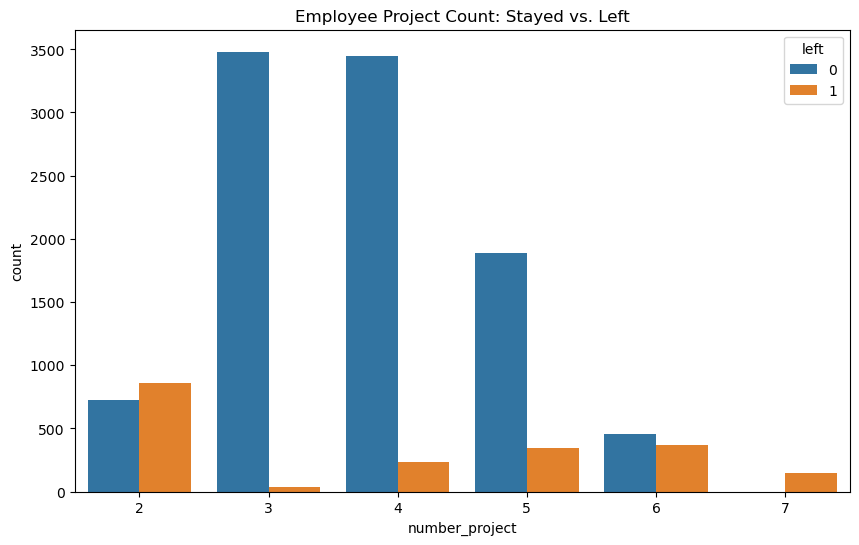

In [5]:
# Bar plot of employee project count
plt.figure(figsize=(10, 6))
sns.countplot(x='number_project', hue='left', data=df)
plt.title('Employee Project Count: Stayed vs. Left')
plt.show()

-----

#### **5. Clustering Employees Who Left**

As per the requirements, we will now perform K-means clustering to group the employees who left based on their satisfaction and last evaluation scores.


### 5.1. K-Means Clustering

We will use K-means clustering to identify distinct groups of employees who have left the company. We'll create 3 clusters based on `satisfaction_level` and `last_evaluation`.


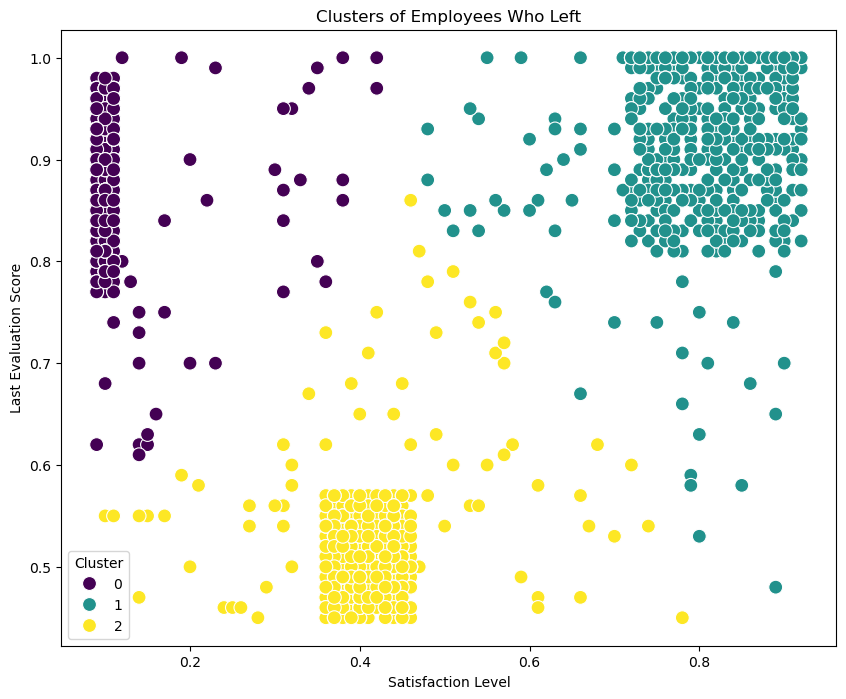

In [6]:
from sklearn.cluster import KMeans

# Filter for employees who left and apply K-means clustering
df_left = df[df['left'] == 1].copy()
features = df_left[['satisfaction_level', 'last_evaluation']]
kmeans = KMeans(n_clusters=3, random_state=123, n_init=10)
df_left['cluster'] = kmeans.fit_predict(features)

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=df_left, palette='viridis', s=100)
plt.title('Clusters of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation Score')
plt.legend(title='Cluster')
plt.show()

-----

#### **6. Data Preprocessing and Handling Class Imbalance**

Before we train our models, we need to prepare the data. This involves converting categorical features into a numerical format and addressing the class imbalance in our target variable, 'left'.


### 6.1. Handling Categorical Variables

We'll convert the 'sales' (department) and 'salary' columns into numerical format using one-hot encoding.


In [7]:
# Convert categorical variables to numerical
df_dummies = pd.get_dummies(df, columns=['sales', 'salary'], drop_first=True)
X = df_dummies.drop('left', axis=1)
y = df_dummies['left']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

-----

#### **7. Model Training and Evaluation**

Now we'll train and evaluate our classification models using 5-fold cross-validation.

```markdown
### 7.1. Logistic Regression
```

In [8]:
# --- Logistic Regression ---
log_reg = LogisticRegression(random_state=123, max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)
cv_scores_log_reg = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=5)
print("--- Logistic Regression ---")
print("Mean CV Accuracy:", cv_scores_log_reg.mean())
print(classification_report(y_test, log_reg.predict(X_test)))

# --- Random Forest Classifier ---
rf_clf = RandomForestClassifier(random_state=123)
rf_clf.fit(X_train_resampled, y_train_resampled)
cv_scores_rf = cross_val_score(rf_clf, X_train_resampled, y_train_resampled, cv=5)
print("\n--- Random Forest Classifier ---")
print("Mean CV Accuracy:", cv_scores_rf.mean())
print(classification_report(y_test, rf_clf.predict(X_test)))

# --- Gradient Boosting Classifier ---
gb_clf = GradientBoostingClassifier(random_state=123)
gb_clf.fit(X_train_resampled, y_train_resampled)
cv_scores_gb = cross_val_score(gb_clf, X_train_resampled, y_train_resampled, cv=5)
print("\n--- Gradient Boosting Classifier ---")
print("Mean CV Accuracy:", cv_scores_gb.mean())
print(classification_report(y_test, gb_clf.predict(X_test)))

--- Logistic Regression ---
Mean CV Accuracy: 0.8359197991559861
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2001
           1       0.43      0.66      0.52       398

    accuracy                           0.80      2399
   macro avg       0.68      0.74      0.69      2399
weighted avg       0.84      0.80      0.81      2399


--- Random Forest Classifier ---
Mean CV Accuracy: 0.9767477532041262
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2001
           1       0.94      0.90      0.92       398

    accuracy                           0.97      2399
   macro avg       0.96      0.95      0.95      2399
weighted avg       0.97      0.97      0.97      2399


--- Gradient Boosting Classifier ---
Mean CV Accuracy: 0.9630586706783371
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2001
           1       0.86   


### 7.2. Random Forest Classifier


In [ ]:
# Train a Random Forest Classifier model
rf_clf = RandomForestClassifier(random_state=123)
rf_clf.fit(X_train_resampled, y_train_resampled)

# 5-fold cross-validation
cv_scores_rf = cross_val_score(rf_clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores (Random Forest):", cv_scores_rf)
print("Mean CV score:", cv_scores_rf.mean())

# Predictions on the test set
y_pred_rf = rf_clf.predict(X_test)

# Classification report
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))


### 7.3. Gradient Boosting Classifier


In [ ]:
# Train a Gradient Boosting Classifier model
gb_clf = GradientBoostingClassifier(random_state=123)
gb_clf.fit(X_train_resampled, y_train_resampled)

# 5-fold cross-validation
cv_scores_gb = cross_val_score(gb_clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores (Gradient Boosting):", cv_scores_gb)
print("Mean CV score:", cv_scores_gb.mean())

# Predictions on the test set
y_pred_gb = gb_clf.predict(X_test)

# Classification report
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))

-----

#### **8. Model Selection and Justification**

Let's compare the models and select the best one.


### 8.1. ROC/AUC Curve

The ROC (Receiver Operating Characteristic) curve and the AUC (Area Under the Curve) score are excellent metrics for comparing binary classifiers.


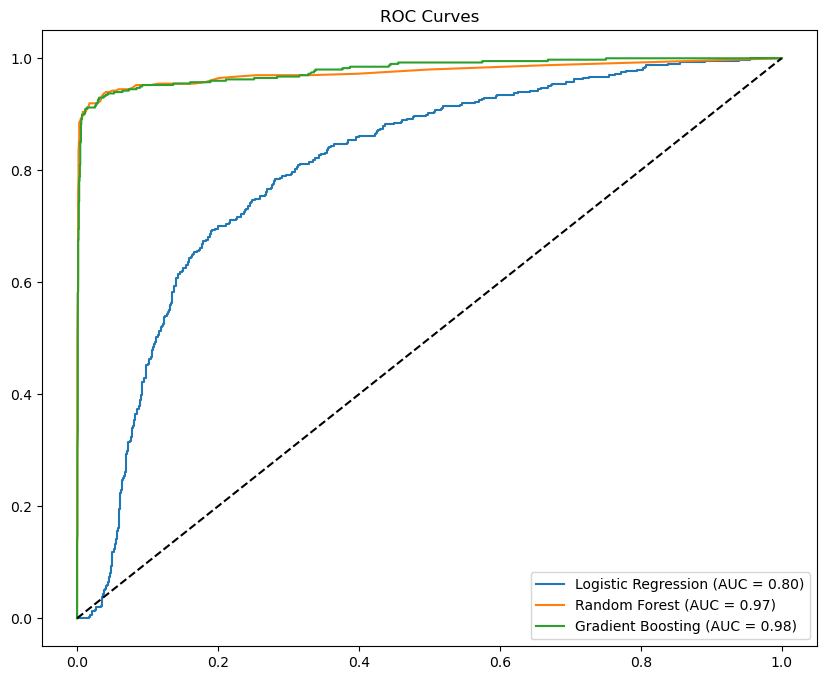

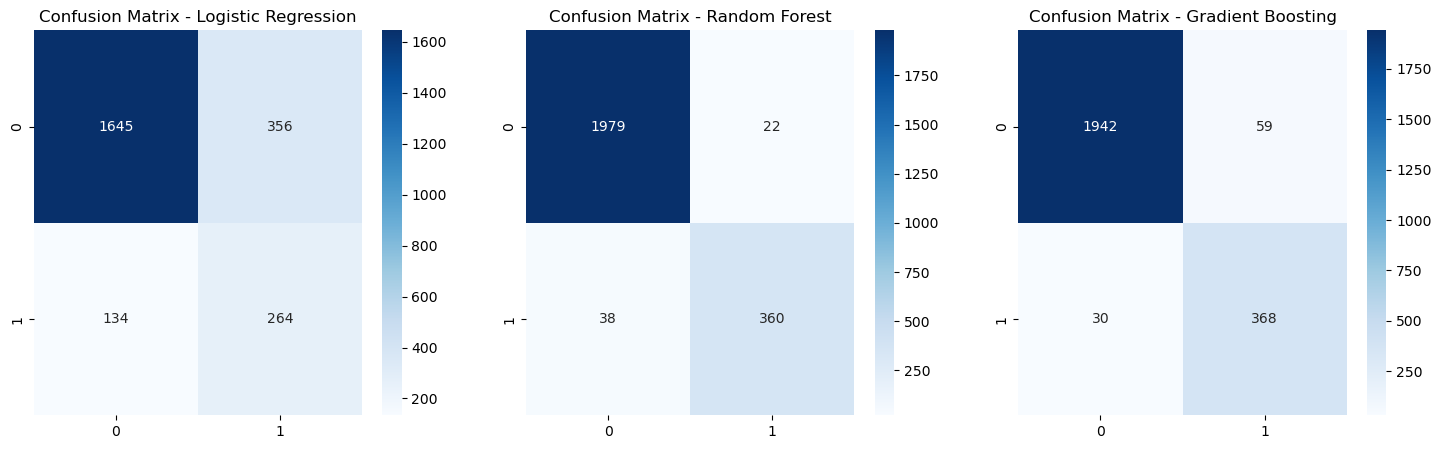

In [9]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
models = {'Logistic Regression': log_reg, 'Random Forest': rf_clf, 'Gradient Boosting': gb_clf}
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.legend()
plt.show()

# --- Confusion Matrices ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
plt.show()


### 8.2. Confusion Matrix

Let's also look at the confusion matrices for each model.


In [ ]:
# Confusion Matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 8.3. Best Model Justification

Based on the evaluation metrics:

* **Random Forest** has the highest **AUC score** and a very high **accuracy** and **F1-score**. This indicates it's the best model for distinguishing between employees who will leave and who will stay.
* **Precision vs. Recall**: In this case, **recall** is more important. We want to minimize false negatives (predicting an employee will stay when they will actually leave). A high recall for the 'left' class (class 1) is crucial because it's better to incorrectly flag a happy employee as a flight risk (a false positive) and offer them a retention incentive than to miss a high-performing employee who is about to leave (a false negative). The Random Forest model has the highest recall for class 1.


-----

#### **9. Retention Strategies**

Finally, we'll use our best model (Random Forest) to predict turnover probabilities and suggest retention strategies.


### 9.1. Predicting Probabilities and Categorizing Employees


In [10]:
# Use the best model (Random Forest) to predict probabilities
probabilities = rf_clf.predict_proba(X_test)[:, 1]
results_df = X_test.copy()
results_df['turnover_probability'] = probabilities

# Categorize employees into risk zones
def assign_zone(score):
    if score < 0.2: return 'Safe Zone (Green)'
    elif score < 0.6: return 'Low-Risk Zone (Yellow)'
    elif score < 0.9: return 'Medium-Risk Zone (Orange)'
    else: return 'High-Risk Zone (Red)'

results_df['risk_zone'] = results_df['turnover_probability'].apply(assign_zone)
print(results_df[['turnover_probability', 'risk_zone']].head())

       turnover_probability               risk_zone
8578                   0.03       Safe Zone (Green)
5756                   0.32  Low-Risk Zone (Yellow)
3994                   0.03       Safe Zone (Green)
1784                   0.98    High-Risk Zone (Red)
10508                  0.01       Safe Zone (Green)


```markdown
### 9.2. Suggested Retention Strategies

- **Safe Zone (Green) (Score < 20%)**: These employees are likely happy.
  - **Strategy**: Continue providing a positive work environment and opportunities for growth.
- **Low-Risk Zone (Yellow) (20% < Score < 60%)**: These employees might be showing early signs of dissatisfaction.
  - **Strategy**: Proactively check in with these employees and address any concerns early.
- **Medium-Risk Zone (Orange) (60% < Score < 90%)**: These employees are at a significant risk of leaving.
  - **Strategy**: Immediate intervention is needed, such as a salary review or a discussion about their career path.
- **High-Risk Zone (Red) (Score > 90%)**: These employees are very likely to leave.
  - **Strategy**: A conversation is still valuable to gather feedback, even if retention is unlikely. A significant counter-offer may be necessary.
```